# Exoplanet Convolutional Neural Network (CNN) Classifier
Here we will use a CNN to classify if a star observed by Kepler contains a exoplanet 

In [66]:
import tensorflow.keras.models
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

First lets load the data and preprocess it.

In [67]:
def load_data(path):
    data = pd.read_csv(path)

    # Convert columns to something more useful.
    for i, column in enumerate(data.columns):
        if 'FLUX' in column:
            data.columns.values[i] = int(column.split('.')[1])
    # Also change labels so 0 is non-exoplanet and 1 is exoplanet
    data.LABEL -= 1
    return data

def normalize_data(df):
    """
    Normalize a Kepler light curve DatFrame with a mean subtraction and 
    """
    # Calculate the mean of each light curve and subtract it
    df_norm = df.copy()
    mean = df_norm.iloc[:, 1:].mean(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].subtract(mean, axis=0)
    # Calculate the standard deviation of each light curve and divide.
    std = df_norm.iloc[:, 1:].std(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].divide(std, axis=0)
    return df_norm


train_data = load_data('./data/exoTrain.csv')
train_data = normalize_data(train_data)

test_data = load_data('./data/exoTest.csv')
test_data = normalize_data(test_data)

Now reshape the arrays to input into the CNN.

In [68]:
train_data_array, train_data_labels = train_data.iloc[:, 1:].values, train_data.iloc[:, 0].values
train_data_array = train_data_array.reshape(*train_data_array.shape, 1)
train_data_labels = train_data_labels.reshape(train_data_labels.shape[0], 1)

test_data_array, test_data_labels = test_data.iloc[:, 1:].values, test_data.iloc[:, 0].values
test_data_array = test_data_array.reshape(*test_data_array.shape, 1)
test_data_labels = test_data_labels.reshape(test_data_labels.shape[0], 1)

print(train_data_array.shape, train_data_labels.shape)
print(test_data_array.shape, test_data_labels.shape)

(5087, 3197, 1) (5087, 1)
(570, 3197, 1) (570, 1)


To ballance the data set we create a batch function to return equal number of exoplanet and non-exoplanet light curves. There will be duplicate light curves.

In [69]:
def light_curve_batch_generator(x, y, batch_size=32):
    """
    Returns equal number of random exoplanets and non-exoplanet detections.
    """
    idx_exo = np.where(y==1)[0]
    idx_nonexo = np.where(y==0)[0]
 
    while True:
        random_idx_exo = np.random.choice(idx_exo, size=batch_size//2, replace=True)
        random_idx_nonexo = np.random.choice(idx_nonexo, size=batch_size//2, replace=True)
        random_idx = np.concatenate((random_idx_exo, random_idx_nonexo))
        np.random.shuffle(random_idx)
        # print(idx, random_idx)
        #print(random_idx)
        train_data = x[random_idx, :, :]
        train_labels = y[random_idx, :]

        for i in range(batch_size):
            random_shift = np.random.randint(train_data.shape[1])
            train_data[i] = np.roll(train_data[i], random_shift, axis=0)
        yield train_data, train_labels

Test the batch generator

In [70]:
model = tensorflow.keras.models.Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=train_data_array.shape[1:]))
model.add(MaxPooling1D(strides=4))
# model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(strides=4))
# model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(strides=4))
# model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPooling1D(strides=4))
model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [71]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 3187, 8)           96        
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 797, 8)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 787, 16)           1424      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 197, 16)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 187, 32)           5664      
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 47, 32)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 37, 64)           

In [72]:
model.compile(optimizer=Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(x=light_curve_batch_generator(train_data_array, train_data_labels), 
                validation_data=(test_data_array, test_data_labels), 
                verbose=2, epochs=60, steps_per_epoch=train_data_array.shape[0]//32)

Epoch 1/60
158/158 - 8s - loss: 0.6792 - accuracy: 0.5597 - val_loss: 0.5683 - val_accuracy: 0.9404
Epoch 2/60
158/158 - 7s - loss: 0.6446 - accuracy: 0.6341 - val_loss: 0.5560 - val_accuracy: 0.7930
Epoch 3/60
158/158 - 7s - loss: 0.5890 - accuracy: 0.7087 - val_loss: 0.4696 - val_accuracy: 0.8053
Epoch 4/60
158/158 - 8s - loss: 0.5582 - accuracy: 0.7257 - val_loss: 0.5422 - val_accuracy: 0.7491
Epoch 5/60
158/158 - 8s - loss: 0.5367 - accuracy: 0.7397 - val_loss: 0.4925 - val_accuracy: 0.7789
Epoch 6/60
158/158 - 7s - loss: 0.5169 - accuracy: 0.7456 - val_loss: 0.4047 - val_accuracy: 0.8140
Epoch 7/60
158/158 - 8s - loss: 0.5003 - accuracy: 0.7567 - val_loss: 0.4738 - val_accuracy: 0.7649
Epoch 8/60
158/158 - 8s - loss: 0.4932 - accuracy: 0.7575 - val_loss: 0.4424 - val_accuracy: 0.7912
Epoch 9/60
158/158 - 7s - loss: 0.4753 - accuracy: 0.7773 - val_loss: 0.4718 - val_accuracy: 0.7754
Epoch 10/60
158/158 - 7s - loss: 0.4618 - accuracy: 0.7807 - val_loss: 0.4737 - val_accuracy: 0.7456

Run with and without batch normalization and look how cleanly the loss decreases.

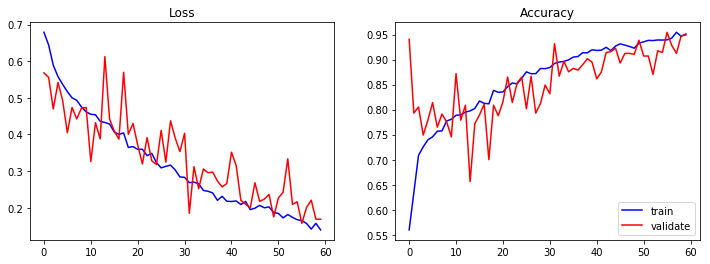

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(hist.history['loss'], color='b')
ax[0].plot(hist.history['val_loss'], color='r')
ax[1].plot(hist.history['accuracy'], color='b', label='train')
ax[1].plot(hist.history['val_accuracy'], color='r', label='validate')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[1].legend();

In [74]:
model.evaluate(test_data_array, test_data_labels, verbose=2)

570/570 - 0s - loss: 0.1692 - accuracy: 0.9491


[0.16921269078003734, 0.9491228]

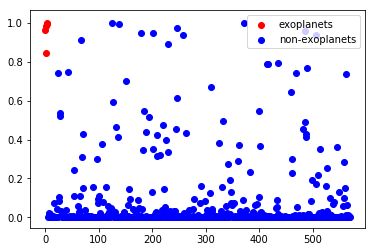

In [75]:
exo_idx = np.where(test_data_labels == 1)[0]
nonexo_idx = np.where(test_data_labels == 0)[0]
cnn_predict = model.predict(test_data_array)

plt.scatter(exo_idx, cnn_predict[exo_idx].flatten(), c='r', label='exoplanets')
plt.scatter(nonexo_idx, cnn_predict[nonexo_idx].flatten(), c='b', label='non-exoplanets')
plt.legend();